In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
# 데이터셋 인스턴스 생성

data = pd.read_csv('C:\\AI\\diabetes.csv')  # CSV 파일 경로

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

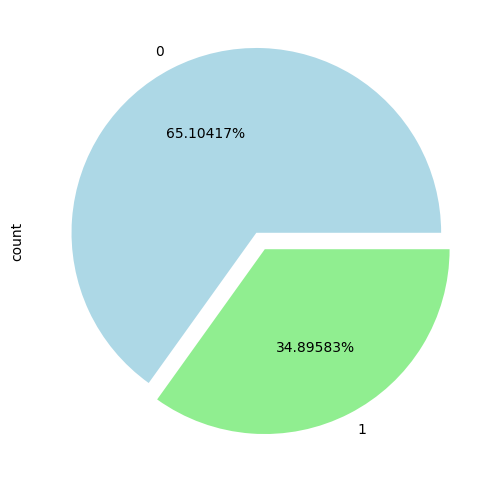

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen'], explode=(0.05, 0.05))

In [5]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [6]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI','DiabetesPedigreeFunction','Age','Outcome']

In [7]:
label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [8]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,86,22,28,0,123,350,29,1
1,1,23,19,22,0,62,196,10,0
2,8,121,17,0,0,30,368,11,1
3,1,27,19,16,62,77,53,0,0
4,0,75,4,28,102,209,514,12,1
...,...,...,...,...,...,...,...,...,...
763,10,39,25,41,108,118,55,42,0
764,2,60,21,20,0,155,187,6,0
765,5,59,22,16,71,58,115,9,0
766,1,64,14,0,0,95,195,26,1


In [9]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [10]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [12]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [13]:

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

# 모델 정의 ( 초기화 함수 안에 활성화 함수 포함 )

In [15]:
class DiabatesDense(nn.Module):
    def __init__(self):
        super(DiabatesDense, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # 이진 분류라서 출력이 1개
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = DiabatesDense()

# 손실 함수 및 최적화 기법 정의

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습

In [17]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        labels = labels.float().unsqueeze(1)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)  이진 분류에서는 사용 X. 다중에서 사용

            probs = torch.sigmoid(outputs)          #이진에서
            predicted = (probs >= 0.5).float()      #사용

            total += labels.size(0)
            correct += (predicted == labels).sum().item()  
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6331, Accuracy: 72.73%
Epoch 2/20, Loss: 0.5715, Accuracy: 76.62%
Epoch 3/20, Loss: 0.5318, Accuracy: 79.22%
Epoch 4/20, Loss: 0.4887, Accuracy: 79.87%
Epoch 5/20, Loss: 0.4769, Accuracy: 77.92%
Epoch 6/20, Loss: 0.4638, Accuracy: 77.92%
Epoch 7/20, Loss: 0.4535, Accuracy: 79.22%
Epoch 8/20, Loss: 0.4535, Accuracy: 79.87%
Epoch 9/20, Loss: 0.4440, Accuracy: 80.52%
Epoch 10/20, Loss: 0.4601, Accuracy: 80.52%
Epoch 11/20, Loss: 0.4558, Accuracy: 80.52%
Epoch 12/20, Loss: 0.4456, Accuracy: 82.47%
Epoch 13/20, Loss: 0.4395, Accuracy: 81.82%
Epoch 14/20, Loss: 0.4464, Accuracy: 82.47%
Epoch 15/20, Loss: 0.4377, Accuracy: 80.52%
Epoch 16/20, Loss: 0.4368, Accuracy: 82.47%
Epoch 17/20, Loss: 0.4226, Accuracy: 81.82%
Epoch 18/20, Loss: 0.4258, Accuracy: 83.12%
Epoch 19/20, Loss: 0.4219, Accuracy: 81.82%
Epoch 20/20, Loss: 0.4202, Accuracy: 81.17%
Training complete.


# 모델 평가

In [18]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        #_, predicted = torch.max(outputs.data, 1) 다중 클래스 분류

        probs = torch.sigmoid(outputs)     #이진에서
        predicted = (probs >= 0.5).float() #사용
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[93 14]
 [15 32]]
F1 Score: 0.81
Precision: 0.81
Recall: 0.81
Specificity: 0.78


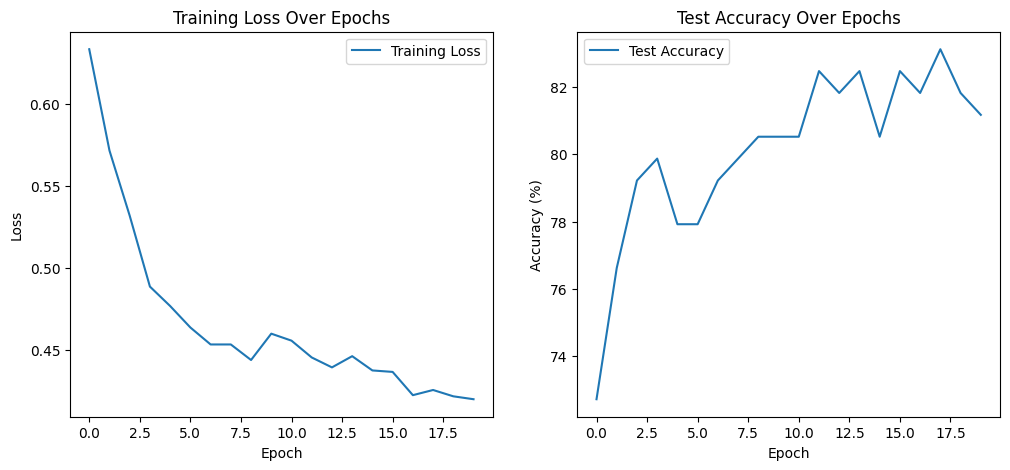

In [19]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()